In [1]:
# Melting Economies 
# Multivariate Econometrics

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
%matplotlib inline
from matplotlib import cm
from statsmodels.tsa.vector_ar.vecm import *
from astropy.io import ascii
import statsmodels.tsa.stattools as ts
from arch.unitroot.cointegration import phillips_ouliaris
from itertools import permutations
#plt.style.use('/home/luuk/Documents/MNRAS_Style.mplstyle')

<h1>Part I: Graphical analysis</h1>

<h3>Read in the data</h3>

In [3]:
# Read in the Excel file with the data
countries = ['Netherlands','Norway', 'Thailand', 'South Africa']
def read_data():
    df = pd.read_excel('./MVE_assignment_2020_dataset.xlsx')
    # Select from df only those for our countries
    df = df[df['cntry.name'].apply(lambda x: x in countries)]
    # Drop columns that are irrelevant (ISO names of countries)
    df = df.drop(['ISO_N3','ISO_C3'],axis=1)
    # Set index to increase readability
    df.columns = ['Country','Year','Precipitation','Radiation','Average Temp','GDP','GDP per Capita','Population','Land','CPI']
    df = df.set_index(['Country','Year'])
    # Replace '..' with nans to avoid problems
    df = df.replace('..',np.nan)
    return df
df = read_data()

In [4]:
# From now on, we only use five of the variables
columns = ['Precipitation','Radiation','Average Temp','GDP per Capita','CPI']
df = df[columns]

<h3>Outliers</h3>

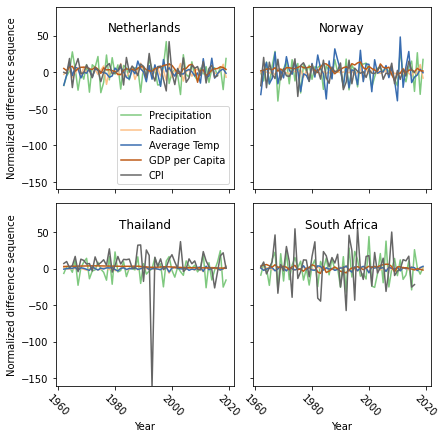

In [26]:
def outliers():
    cmap = cm.get_cmap('Accent',5)
    cmap = cmap(np.arange(0,5))
    fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,sharey=True,figsize=(6,6))
    for ax_iter,country in enumerate(countries):
        ax = [ax1,ax2,ax3,ax4][ax_iter]
        for col_iter,col in enumerate(df.columns):
            normed = np.diff(df.loc[country][col] / df.loc[country][col].loc[1961]*100)
            ax.plot(df.loc[country].index.values[1:], normed,color=cmap[col_iter],label=col)
        ax.set_title(country,x=0.5,y=0.83)
        ax.set_ylim(-160,90)
        ax.grid(False)

    ax3.set_xlabel('Year')
    
    ax3.set_xticklabels(ax3.get_xticks().astype(int),rotation=-45)
    ax4.set_xlabel('Year')
    ax4.set_xticklabels(ax4.get_xticks().astype(int),rotation=-45)
    ax1.legend(loc='lower right')
    ax1.set_ylabel('Normalized difference sequence')
    ax3.set_ylabel('Normalized difference sequence')
    plt.tight_layout(pad=0)
    plt.grid(False)
    plt.savefig('Outlier_detection.pdf',bbox_inches='tight')
outliers()

<h3>Correlogram</h3>

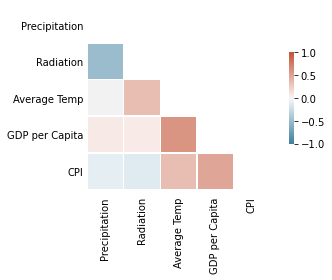

In [8]:
def correlogram():
    corr_mat = 0
    for i,country in enumerate(countries):
        try:
            corr_mat += df.loc[country].corr()
        except:
            corr_mat = df.loc[country].corr()

    corr = corr_mat/4
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots()

    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.tick_params(axis='x', which='minor', bottom=False, top=False)
    ax.tick_params(axis='x', which='major', bottom=False, top=False)
    ax.tick_params(axis='y', which='minor', length=0)
    ax.tick_params(axis='y', which='major', length=0)
    plt.tight_layout()
    plt.savefig('Correlogram.pdf')
correlogram()

<h3>Visually check for I(0),I(1),I(2)</h3>

An ideal time series has stationarity. That means that a shift in time doesn’t cause a change in the shape of the distribution. Unit root processes are one cause for non-stationarity. 

We can visually identify unit root processes versus trend stationary processes by looking at behaviour after shocks. If you have unit roots in your time series, a series of successive differences, d, can transform the time series into one with stationarity. The differences are denoted by I(d), where d is the order of integration. Non-stationary time series that can be transformed in this way are called series integrated of order k. Usually, the order of integration is either I(0) or I(1); It’s rare to see values for d that are 2 or more.

We can graphically check for stationarity by looking at the behaviour after a shock occurs. A (trend) stationary sequence will return to its original trend. An integrated sequence will return to the trend but at a different level.

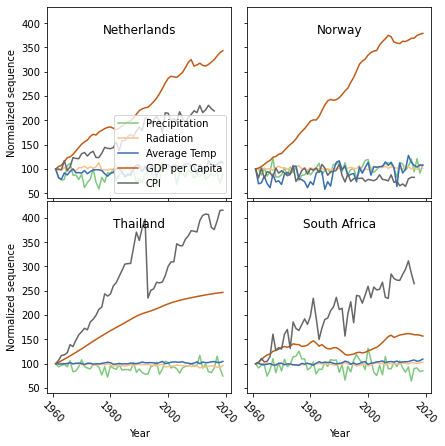

In [30]:
def visual_inspection():
    cmap = cm.get_cmap('Accent',5)
    cmap = cmap(np.arange(0,5))
    fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,sharey=True,figsize=(6,6))
    for ax_iter,country in enumerate(countries):
        ax = [ax1,ax2,ax3,ax4][ax_iter]
        for col_iter,col in enumerate(df.columns):
            normed = 100*df.loc[country,col] / df.loc[country,col].loc[1961]
            ax.plot(df.loc[country].index.values, normed,color=cmap[col_iter],label=col)
        ax.set_title(country,x=0.5,y=0.83)
        #ax.set_ylim(-160,90)
        ax.grid(False)

    ax3.set_xlabel('Year')
    ax3.set_xticklabels(ax3.get_xticks().astype(int),rotation=-45)
    ax4.set_xlabel('Year')
    ax4.set_xticklabels(ax4.get_xticks().astype(int),rotation=-45)
    ax4.set_xlabel('Year')
    ax1.legend(loc='lower right')
    ax1.set_ylabel('Normalized sequence')
    ax3.set_ylabel('Normalized sequence')
    plt.tight_layout(pad=0)
    plt.grid(False)
    plt.savefig('visual_inspection.pdf',bbox_inches='tight')
visual_inspection()


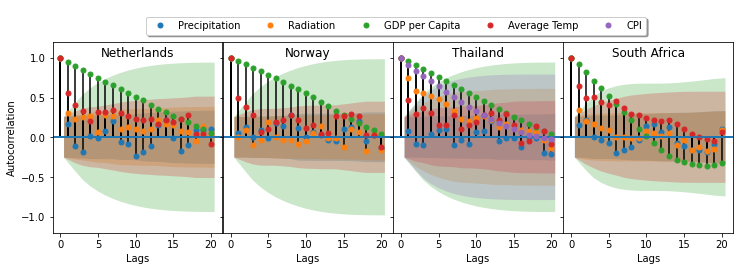

In [347]:
import statsmodels.api as sm
fig, axes = plt.subplots(1,4,figsize=(10,3),sharex=True,sharey=True)

ax=axes[0]
sm.graphics.tsa.plot_acf(df.loc['Netherlands']['Precipitation'], lags=20,ax=ax,label='Precipitation')
sm.graphics.tsa.plot_acf(df.loc['Netherlands']['Radiation'], lags=20,ax=ax, label='Radiation')
sm.graphics.tsa.plot_acf(df.loc['Netherlands']['GDP per Capita'], lags=20,ax=ax,label='GDP per Capita')
sm.graphics.tsa.plot_acf(df.loc['Netherlands']['Average Temp'], lags=20,ax=ax, label='Average Temp')
sm.graphics.tsa.plot_acf(df.loc['Netherlands']['CPI'], lags=20,ax=ax, label='CPI')

ax=axes[1]
sm.graphics.tsa.plot_acf(df.loc['Norway']['Precipitation'], lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Norway']['Radiation'], lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Norway']['GDP per Capita'], lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Norway']['Average Temp'], lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Norway']['CPI'], lags=20,ax=ax, label='CPI')

ax=axes[2]
sm.graphics.tsa.plot_acf(df.loc['Thailand']['Precipitation'], lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Thailand']['Radiation'], lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Thailand']['GDP per Capita'], lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Thailand']['Average Temp'], lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Thailand']['CPI'], lags=20,ax=ax, label='CPI')

ax=axes[3]
sm.graphics.tsa.plot_acf(df.loc['South Africa']['Precipitation'], lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['South Africa']['Radiation'], lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['South Africa']['GDP per Capita'], lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['South Africa']['Average Temp'], lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['South Africa']['CPI'], lags=20,ax=ax, label='CPI')

axes[0].set_title('Netherlands',y=0.89)
axes[1].set_title('Norway',y=0.89)
axes[2].set_title('Thailand',y=0.89)
axes[3].set_title('South Africa',y=0.89)

for ax in axes:
    ax.set_xlabel('Lags')
    ax.set_ylim(-1.2,1.2)
axes[0].set_ylabel('Autocorrelation')

handles, labels = axes[0].get_legend_handles_labels()
handles = [handles[w] for w in [1,3,5,7,9]]
labels = [labels[w] for w in [1,3,5,7,9]]
lgd=fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 1.2),
          ncol=5, fancybox=True, shadow=True)


plt.tight_layout(pad=-0.3)
plt.savefig('ACF_plots.pdf',bbox_inches='tight',bbox_extra_artists=(lgd,))
plt.show()

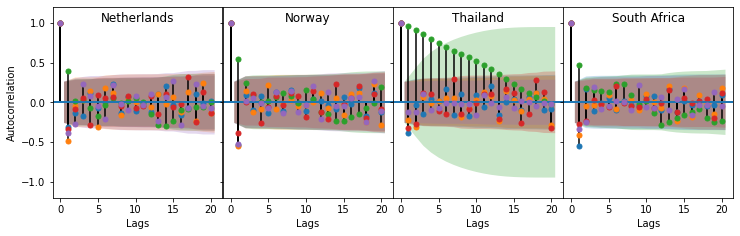

In [350]:
import statsmodels.api as sm
fig, axes = plt.subplots(1,4,figsize=(10,3),sharex=True,sharey=True)

ax=axes[0]
sm.graphics.tsa.plot_acf(df.loc['Netherlands']['Precipitation'].diff().dropna(), lags=20,ax=ax,label='Precipitation')
sm.graphics.tsa.plot_acf(df.loc['Netherlands']['Radiation'].diff().dropna(), lags=20,ax=ax, label='Radiation')
sm.graphics.tsa.plot_acf(df.loc['Netherlands']['GDP per Capita'].diff().dropna(), lags=20,ax=ax,label='GDP per Capita')
sm.graphics.tsa.plot_acf(df.loc['Netherlands']['Average Temp'].diff().dropna(), lags=20,ax=ax, label='Average Temp')
sm.graphics.tsa.plot_acf(df.loc['Netherlands']['CPI'].diff().dropna(), lags=20,ax=ax, label='CPI')

ax=axes[1]
sm.graphics.tsa.plot_acf(df.loc['Norway']['Precipitation'].diff().dropna(), lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Norway']['Radiation'].diff().dropna(), lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Norway']['GDP per Capita'].diff().dropna(), lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Norway']['Average Temp'].diff().dropna(), lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Norway']['CPI'].diff().dropna(), lags=20,ax=ax, label='CPI')

ax=axes[2]
sm.graphics.tsa.plot_acf(df.loc['Thailand']['Precipitation'].diff().dropna(), lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Thailand']['Radiation'].diff().dropna(), lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Thailand']['GDP per Capita'].diff().dropna(), lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Thailand']['Average Temp'].diff().dropna(), lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['Thailand']['CPI'].diff().dropna(), lags=20,ax=ax, label='CPI')

ax=axes[3]
sm.graphics.tsa.plot_acf(df.loc['South Africa']['Precipitation'].diff().dropna(), lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['South Africa']['Radiation'].diff().dropna(), lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['South Africa']['GDP per Capita'].diff().dropna(), lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['South Africa']['Average Temp'].diff().dropna(), lags=20,ax=ax)
sm.graphics.tsa.plot_acf(df.loc['South Africa']['CPI'].diff().dropna(), lags=20,ax=ax, label='CPI')

axes[0].set_title('Netherlands',y=0.89)
axes[1].set_title('Norway',y=0.89)
axes[2].set_title('Thailand',y=0.89)
axes[3].set_title('South Africa',y=0.89)

for ax in axes:
    ax.set_xlabel('Lags')
    ax.set_ylim(-1.2,1.2)
axes[0].set_ylabel('Autocorrelation')

handles, labels = axes[0].get_legend_handles_labels()
handles = [handles[w] for w in [1,3,5,7,9]]
labels = [labels[w] for w in [1,3,5,7,9]]
#lgd=fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 1.2),
#          ncol=5, fancybox=True, shadow=True)


plt.tight_layout(pad=-0.3)
plt.savefig('ACF_diff_plots.pdf',bbox_inches='tight')
plt.show()

In [371]:
df.loc['Netherlands'].corr()

,Precipitation,Radiation,Average Temp,GDP per Capita,CPI
Precipitation,1.000000,-0.480646,0.129702,0.085870,0.072098
Radiation,-0.480646,1.000000,0.640129,0.599255,0.543053
Average Temp,0.129702,0.640129,1.000000,0.715880,0.647365
GDP per Capita,0.085870,0.599255,0.715880,1.000000,0.951465
CPI,0.072098,0.543053,0.647365,0.951465,1.000000


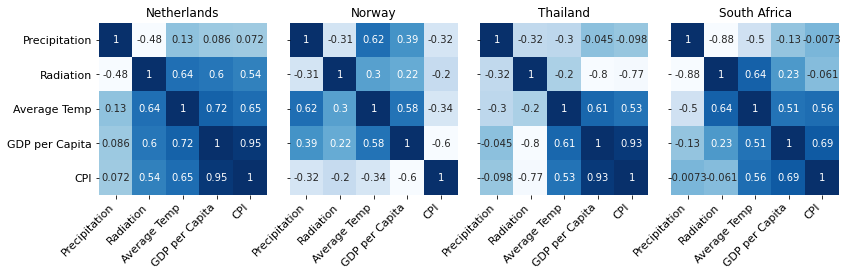

In [411]:
import statsmodels.api as sm
from statsmodels.graphics.correlation import plot_corr
import seaborn as sns
#sns.set_theme()
fig, axes = plt.subplots(1,4,figsize=(11,3),sharex=False,sharey=True)

cmap='Blues'
ax=axes[0]
#plot_corr(df.loc['Netherlands'].corr(), ,ax=ax,cmap='Blues',xnames=df.corr())
sns.heatmap(df.loc['Netherlands'].corr(), annot=True,ax=ax, cbar=False,cmap=cmap)

ax=axes[1]
sns.heatmap(df.loc['Norway'].corr(), annot=True,ax=ax, cbar=False,cmap=cmap)

ax=axes[2]
sns.heatmap(df.loc['Thailand'].corr(), annot=True,ax=ax, cbar=False,cmap=cmap)

ax=axes[3]
sns.heatmap(df.loc['South Africa'].corr(), annot=True,ax=ax, cbar=False,cmap=cmap)

axes[0].set_title('Netherlands',y=0.89)
axes[1].set_title('Norway',y=0.89)
axes[2].set_title('Thailand',y=0.89)
axes[3].set_title('South Africa',y=0.89)

axes[0].set_xticklabels(axes[0].get_xticklabels(),size=11,rotation=45,ha="right")
axes[1].set_xticklabels(axes[0].get_xticklabels(),size=11,rotation=45,ha="right")
axes[2].set_xticklabels(axes[0].get_xticklabels(),size=11,rotation=45,ha="right")
axes[3].set_xticklabels(axes[0].get_xticklabels(),size=11,rotation=45,ha="right")

axes[0].set_yticklabels(axes[0].get_xticklabels(),size=11)



plt.tight_layout(pad=-2.3)
plt.savefig('corr_plots.pdf',bbox_inches='tight')
plt.show()

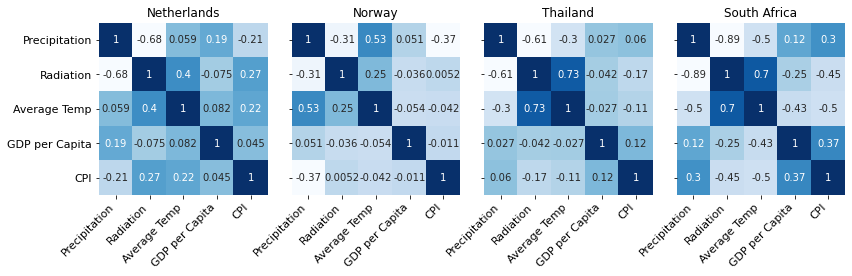

In [410]:
import statsmodels.api as sm
from statsmodels.graphics.correlation import plot_corr
import seaborn as sns
#sns.set_theme()
fig, axes = plt.subplots(1,4,figsize=(11,3),sharex=False,sharey=True)

cmap='Blues'
ax=axes[0]
#plot_corr(df.loc['Netherlands'].corr(), ,ax=ax,cmap='Blues',xnames=df.corr())
sns.heatmap(df.loc['Netherlands'].diff().dropna().corr(), annot=True,ax=ax, cbar=False,cmap=cmap)

ax=axes[1]
sns.heatmap(df.loc['Norway'].diff().dropna().corr(), annot=True,ax=ax, cbar=False,cmap=cmap)

ax=axes[2]
sns.heatmap(df.loc['Thailand'].diff().dropna().corr(), annot=True,ax=ax, cbar=False,cmap=cmap)

ax=axes[3]
sns.heatmap(df.loc['South Africa'].diff().dropna().corr(), annot=True,ax=ax, cbar=False,cmap=cmap)

axes[0].set_title('Netherlands',y=0.89)
axes[1].set_title('Norway',y=0.89)
axes[2].set_title('Thailand',y=0.89)
axes[3].set_title('South Africa',y=0.89)

axes[0].set_xticklabels(axes[0].get_xticklabels(),size=11,rotation=45,ha="right")
axes[1].set_xticklabels(axes[0].get_xticklabels(),size=11,rotation=45,ha="right")
axes[2].set_xticklabels(axes[0].get_xticklabels(),size=11,rotation=45,ha="right")
axes[3].set_xticklabels(axes[0].get_xticklabels(),size=11,rotation=45,ha="right")

axes[0].set_yticklabels(axes[0].get_xticklabels(),size=11)



plt.tight_layout(pad=-2.3)
plt.savefig('corr_diff_plots.pdf',bbox_inches='tight')
plt.show()

<h1>Part II: order of integration</h1>

In [669]:
class KPSS_ADF():
    def __init__(self,df):
        self.df = df
        self.adf_results  = pd.DataFrame()
        self.kpss_results = pd.DataFrame()
        
        self.run_adf()
        self.run_kpss()
        self.transform()
        self.process_results()
        
        return
    
    def transform(self):
        self.adf_results   = self.adf_results.set_index(['Country','Variable'])
        self.kpss_results = self.kpss_results.set_index(['Country','Variable'])
  
    def adf_test(self,timeseries):
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        return dfoutput
    

    def kpss_test(self,timeseries):
        kpsstest = kpss(timeseries, regression='c', nlags="auto")
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        return kpss_output
        
    def run_adf(self):
        for country in countries:
            for variable in columns:
                timeseries = self.df.loc[country,variable].dropna()
                ADF_result = self.adf_test(timeseries)
                pval = ADF_result[1]
                lags = ADF_result[2]
                self.adf_results = self.adf_results.append({'Country':country,
                                                            'Variable':variable,
                                                            'ADF_pval':pval,
                                                            'ADF_lags':lags},
                                                            ignore_index=True)
            
        
    def run_kpss(self):
        for country in countries:
            for variable in columns:
                timeseries = self.df.loc[country,variable].dropna()
                KPSS_result = self.kpss_test(timeseries)
                pval = KPSS_result[1]
                lags = KPSS_result[2]
                self.kpss_results = self.kpss_results.append({'Country':country,
                                                            'Variable':variable,
                                                            'KPSS_pval':pval,
                                                            'KPSS_lags':lags},
                                                            ignore_index=True)
            
    def process_results(self):
        ADF_stationary = self.adf_results['ADF_pval']
        KPSS_stationary = self.kpss_results['KPSS_pval']

        stationary_result = self.kpss_results['KPSS_pval'].copy()
        stationary_result[:]=0
        # ADF pval >0.05:  non stationary
        # ADF pval <0.05:  stationary
        # KPSS pval >0.05: stationary
        # KPSS pval <0.05: non stationary
        
        pval = 0.05
        
        for country in countries:
            for variable in columns:
                if ADF_stationary.loc[country,variable]<pval:
                    # ADF stationary
                    if KPSS_stationary.loc[country,variable]>pval:
                        # KPSS stationary
                        res = 'S'
                    elif KPSS_stationary.loc[country,variable]<pval:
                        # KPSS non stationary
                        res = 'D-S'
                elif ADF_stationary.loc[country,variable]>pval:
                    # ADF non stationary
                    if KPSS_stationary.loc[country,variable]>pval:
                        res = 'T-S'
                    elif KPSS_stationary.loc[country,variable]<pval:
                        res = 'N-S'
                stationary_result.loc[country,variable] = res
        stationary_result = pd.DataFrame(stationary_result)
        self.stationary_result = stationary_result.unstack()
    
    def lags(self):
        ADF_stationary = self.adf_results['ADF_lags']
        KPSS_stationary = self.kpss_results['KPSS_lags']
        merged = pd.merge(ADF_stationary, KPSS_stationary,left_index=True,right_index=True)
        merged = merged.unstack()
        return merged.swaplevel(0, 1, 1).sort_index(1)
        
        
run_KPSS_ADF = KPSS_ADF(df)

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:16

In [670]:
run_KPSS_ADF.stationary_result

KPSS_pval                                            
Variable     Average Temp  CPI GDP per Capita Precipitation Radiation
Country                                                              
Netherlands           D-S  N-S            N-S             S       D-S
Norway                N-S  N-S            N-S           D-S         S
South Africa          N-S  N-S            N-S             S         S
Thailand              N-S  N-S            D-S             S       N-S

In [141]:
run_KPSS_ADF.lags()

Variable     Average Temp                CPI           GDP per Capita  \
                 ADF_lags KPSS_lags ADF_lags KPSS_lags       ADF_lags   
Country                                                                 
Netherlands           0.0       4.0      3.0       4.0            1.0   
Norway                5.0       4.0      2.0       4.0            1.0   
South Africa          5.0       4.0      2.0       4.0            1.0   
Thailand              2.0       3.0      0.0       4.0            8.0   

Variable               Precipitation           Radiation            
             KPSS_lags      ADF_lags KPSS_lags  ADF_lags KPSS_lags  
Country                                                             
Netherlands        4.0           0.0       0.0       0.0       3.0  
Norway             4.0           0.0       2.0       0.0       2.0  
South Africa       4.0           0.0       3.0       0.0       3.0  
Thailand           4.0           0.0       1.0       2.0       4.0

<h3>Granger Causality</h3>

In [ ]:
# imports the permutation function to generate all permutations of 2 of the FANG stocks
from itertools import permutations
# imports test for Granger Causality (does variable x have value in predicting y)
from statsmodels.tsa.stattools import grangercausalitytests

In [436]:
def find_granger_causality(land):
    variables = df.columns
    data = df.loc[land]
    # creates a list of tuples containing the permutations of length 2 of the FANG stocks
    var_perms = list(permutations(variables, 2))
    granger_df = pd.DataFrame(index=variables, columns=variables)
    granger_df_sign = pd.DataFrame(index=variables, columns=variables)
    # loops through the list of stock permutations
    for i in range(len(var_perms)):
        # converts the tuple to a list so it can be passed to the dataframe for column selection
        temp_list = list(var_perms[i])
        # creates a temporary dataframe of just the two variables
        temp_df = data[temp_list].diff().dropna()
        # prints which permutation is being tested for interpretability
        #print('Does a lag of ' + temp_list[1] + ' predict ' + temp_list[0])
        # prints the results of a Granger Causality test for each permutation with 1 lage
        granger_output = grangercausalitytests(temp_df, maxlag = 1, addconst = True, verbose = False)
        beta_OLS = granger_output[1][1][0].params[0]
        # leaves two spaces for readability
        granger_df.loc[temp_list[0],temp_list[1]] = granger_output[1][0]['ssr_chi2test'][1]
        granger_df_sign.loc[temp_list[0],temp_list[1]] = beta_OLS / np.abs(beta_OLS)
    granger = (granger_df<0.1).stack()
    granger_df_sign = granger_df_sign.stack()[granger].dropna()
    granger = granger[granger].dropna()
    granger[granger] = land
    return granger, granger_df_sign


def combine_granger():
    granger_dfs = [find_granger_causality(w)[0] for w in countries]
    granger_dfs_beta = [find_granger_causality(w)[1] for w in countries]
    a = pd.DataFrame(pd.concat(granger_dfs).sort_index()).reset_index()
    #b = pd.DataFrame(pd.concat(granger_dfs_beta).sort_index()).reset_index()
    a.columns=['col1','col2','country']
    #b.columns=['col1','col2','beta_OLS']
    a=a.set_index(['col1','col2'])
    #b=b.set_index(['col1','col2'])
    
    a = pd.get_dummies(a).groupby(['col1','col2']).sum()
    a['NL'] = 0
    a.columns = ['NO','SA','TH','NL']
    a=a[['NL','NO','SA','TH']]
    #return a
    return a
combine_granger()
#print(combine_granger().to_latex())

<h1>Part III: Cointegration analysis</h1>

<h3>VECM model</h3>

In [5]:
# imports VECM for VECM modeling
from statsmodels.tsa.vector_ar.vecm import VECM

# estimates the VECM on the closing prices with 4 lags, 1 cointegrating relationship, and
# a constant within the cointegration relationship
def fit_vecm(land):
    estimate_vecm = VECM(endog = df.loc[land].dropna(), k_ar_diff =6, coint_rank = 1, deterministic = 'li')
    estimate_vecm_fit = estimate_vecm.fit()
    estimate_vecm_fit.summary()
    return estimate_vecm_fit

def predict_vecm(land):
    estimate_vecm_fit = fit_vecm(land)
    #fig,ax=plt.subplots()
    ahead=30
    mid, lower, upper = estimate_vecm_fit.predict(ahead, alpha=0.05)
    y = estimate_vecm_fit.y_all.T
    n_last_obs = None
    y = y[estimate_vecm_fit.k_ar:] if n_last_obs is None else y[-n_last_obs:]
    plot_var_forc(y, mid, lower, upper,ahead, names=df.columns,
                       plot_stderr=True,
                       legend_options={"loc": "lower left"})

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


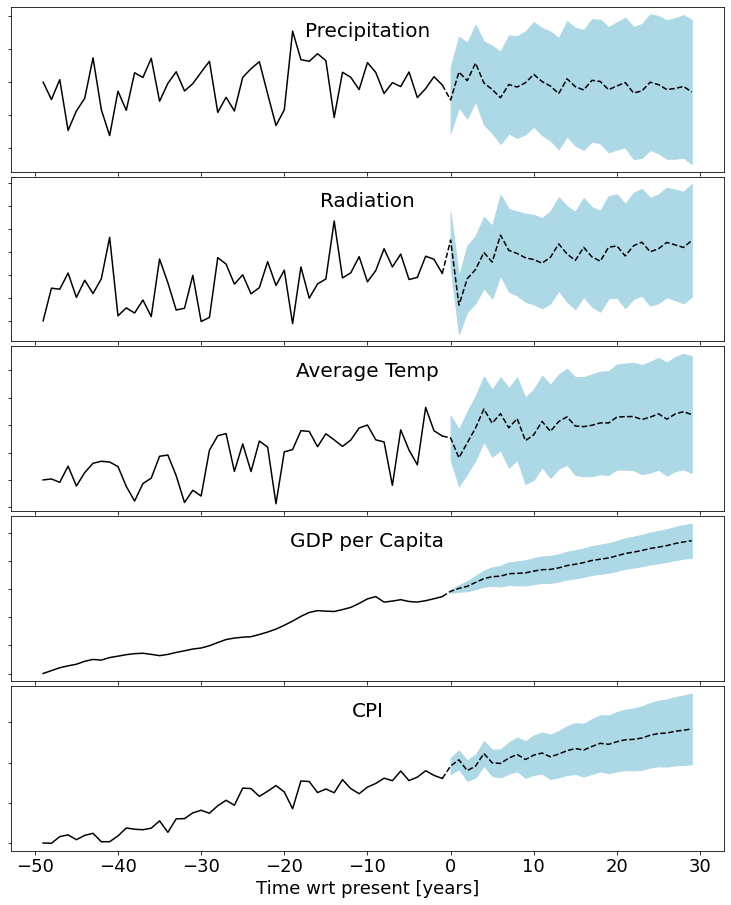

In [32]:
    
def plot_var_forc(prior, forc, err_upper, err_lower,ahead,
                  index=None, names=None, plot_stderr=True,
                  legend_options=None,norm=True):
    import matplotlib.pyplot as plt

    n, k = prior.shape
    rows, cols = k, 1

    

    prange = np.arange(n) -n
    rng_f = np.arange(n - 1, n + len(forc)) -n
    rng_err = np.arange(n, n + len(forc)) -n
    if norm:
        divide = prior[0]
        prior = prior/divide
        err_upper = err_upper/divide
        err_lower = err_lower/divide
        forc = forc/divide
    fig,axarr = plt.subplots(ncols=1,nrows=k,sharex=True,figsize=(10,12))
    for j in range(k):
        ax = axarr[j]#plt.subplot(rows, cols, j+1)

        p1 = ax.plot(prange, prior[:, j], 'k', label='Observed')
        p2 = ax.plot(rng_f, np.r_[prior[-1:, j], forc[:, j]], 'k--',
                     label='Forecast')

        if plot_stderr:
            p3 = ax.fill_between(rng_err, err_lower[:, j],err_upper[:, j],color='lightblue',
                         label='Forc 2 STD err')
            #ax.plot(rng_err, err_lower[:, j], 'k-.')
        
        if names is not None:
            ax.set_title(names[j],y=0.78,fontsize=20)
        #ax.set_xlim(prange[0],prange[-1]+5)
        if legend_options is None:
            legend_options = {"loc": "upper right"}
        #ax.legend(**legend_options,fontsize=18)
        ax.set_yticklabels([],size=18)
    plt.tight_layout(pad=0.15)
    ax.set_xlabel('Time wrt present [years]',size=18)
    ax.set_xticklabels(ax.get_xticklabels(),size=18)
    
    plt.savefig('VECM_prediction.pdf',bbox_inches='tight')
    return fig


predict_vecm('Netherlands')

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


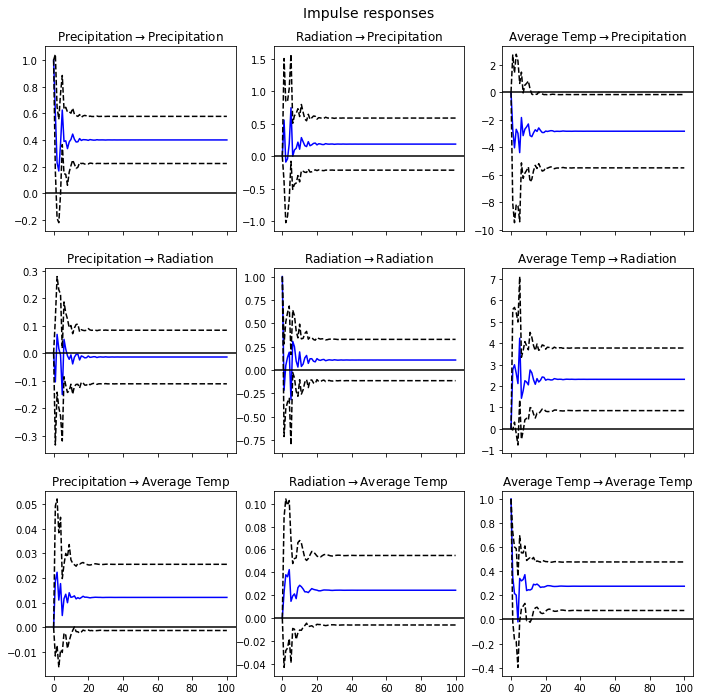

In [173]:
from statsmodels.compat.python import lrange
import statsmodels.tsa.vector_ar.util as util
def fit_vecm(land):
    estimate_vecm = VECM(endog = df.loc[land,['Precipitation', 'Radiation', 'Average Temp']].dropna(), k_ar_diff = 4, coint_rank = 1, deterministic = 'ci')
    estimate_vecm_fit = estimate_vecm.fit()
    estimate_vecm_fit.summary()
    return estimate_vecm_fit

def plot_irf(land):
    estimated_vecm = fit_vecm(land)
    irf = estimated_vecm.irf(100)
    plotter_irf(irf)
    
    
def plotter_irf(irf, orth=False, *, impulse=None, response=None,
             signif=0.05, plot_params=None, figsize=(10, 10),
             subplot_params=None, plot_stderr=True, stderr_type='asym',
             repl=1000, seed=None, component=None):
        """
        Plot impulse responses

        Parameters
        ----------
        orth : bool, default False
            Compute orthogonalized impulse responses
        impulse : {str, int}
            variable providing the impulse
        response : {str, int}
            variable affected by the impulse
        signif : float (0 < signif < 1)
            Significance level for error bars, defaults to 95% CI
        subplot_params : dict
            To pass to subplot plotting funcions. Example: if fonts are too big,
            pass {'fontsize' : 8} or some number to your taste.
        plot_params : dict

        figsize : (float, float), default (10, 10)
            Figure size (width, height in inches)
        plot_stderr : bool, default True
            Plot standard impulse response error bands
        stderr_type : str
            'asym': default, computes asymptotic standard errors
            'mc': monte carlo standard errors (use rpl)
        repl : int, default 1000
            Number of replications for Monte Carlo and Sims-Zha standard errors
        seed : int
            np.random.seed for Monte Carlo replications
        component: array or vector of principal component indices
        """
        periods = irf.periods
        model = irf.model
        svar = irf.svar

        if orth and svar:
            raise ValueError("For SVAR system, set orth=False")

        irfs = irf._choose_irfs(orth, svar)
        if orth:
            title = 'Impulse responses (orthogonalized)'
        elif svar:
            title = 'Impulse responses (structural)'
        else:
            title = 'Impulse responses'

        if plot_stderr is False:
            stderr = None

        elif stderr_type not in ['asym', 'mc', 'sz1', 'sz2','sz3']:
            raise ValueError("Error type must be either 'asym', 'mc','sz1','sz2', or 'sz3'")
        else:
            if stderr_type == 'asym':
                stderr = irf.cov(orth=orth)
            if stderr_type == 'mc':
                stderr = irf.errband_mc(orth=orth, svar=svar,
                                         repl=repl, signif=signif,
                                         seed=seed)
            if stderr_type == 'sz1':
                stderr = irf.err_band_sz1(orth=orth, svar=svar,
                                           repl=repl, signif=signif,
                                           seed=seed,
                                           component=component)
            if stderr_type == 'sz2':
                stderr = irf.err_band_sz2(orth=orth, svar=svar,
                                           repl=repl, signif=signif,
                                           seed=seed,
                                           component=component)
            if stderr_type == 'sz3':
                stderr = irf.err_band_sz3(orth=orth, svar=svar,
                                           repl=repl, signif=signif,
                                           seed=seed,
                                           component=component)

        fig = irf_grid_plot(irfs, stderr, impulse, response,
                                     irf.model.names, title, signif=signif,
                                     subplot_params=subplot_params,
                                     plot_params=plot_params,
                                     figsize=figsize,
                                     stderr_type=stderr_type)
        return fig
def _get_irf_plot_config(names, impcol, rescol):
    nrows = ncols = k = len(names)
    if impcol is not None and rescol is not None:
        # plot one impulse-response pair
        nrows = ncols = 1
        j = util.get_index(names, impcol)
        i = util.get_index(names, rescol)
        to_plot = [(j, i, 0, 0)]
    elif impcol is not None:
        # plot impacts of impulse in one variable
        ncols = 1
        j = util.get_index(names, impcol)
        to_plot = [(j, i, i, 0) for i in range(k)]
    elif rescol is not None:
        # plot only things having impact on particular variable
        ncols = 1
        i = util.get_index(names, rescol)
        to_plot = [(j, i, j, 0) for j in range(k)]
    else:
        # plot everything
        to_plot = [(j, i, i, j) for i in range(k) for j in range(k)]

    return nrows, ncols, to_plot
def adjust_subplots(**kwds):
    import matplotlib.pyplot as plt

    passed_kwds = dict(bottom=0.05, top=0.925,
                       left=0.05, right=0.95,
                       hspace=0.2)
    passed_kwds.update(kwds)
    plt.subplots_adjust(**passed_kwds)
    
def plot_with_error(y, error, x=None, axes=None, value_fmt='k',
                    error_fmt='k--', alpha=0.05, stderr_type = 'asym'):
    """
    Make plot with optional error bars
    Parameters
    ----------
    y :
    error : array or None
    """
    import matplotlib.pyplot as plt

    if axes is None:
        axes = plt.gca()

    x = x if x is not None else lrange(len(y))
    plot_action = lambda y, fmt: axes.plot(x, y, fmt)
    plot_action(y, value_fmt)

    #changed this
    if error is not None:
        if stderr_type == 'asym':
            q = util.norm_signif_level(alpha)
            plot_action(y - q * error, error_fmt)
            plot_action(y + q * error, error_fmt)
        if stderr_type in ('mc','sz1','sz2','sz3'):
            plot_action(error[0], error_fmt)
            plot_action(error[1], error_fmt)
            
def irf_grid_plot(values, stderr, impcol, rescol, names, title,
                  signif=0.05, hlines=None, subplot_params=None,
                  plot_params=None, figsize=(10,10), stderr_type='asym'):
    """
    Reusable function to make flexible grid plots of impulse responses and
    comulative effects
    values : (T + 1) x k x k
    stderr : T x k x k
    hlines : k x k
    """
    import matplotlib.pyplot as plt

    if subplot_params is None:
        subplot_params = {}
    if plot_params is None:
        plot_params = {}

    nrows, ncols, to_plot = _get_irf_plot_config(names, impcol, rescol)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True,
                             squeeze=False, figsize=figsize)

    # fill out space
    adjust_subplots()

    fig.suptitle(title, fontsize=14)

    subtitle_temp = r'%s$\rightarrow$%s'

    k = len(names)

    rng = lrange(len(values))
    for (j, i, ai, aj) in to_plot:
        ax = axes[ai][aj]

        # HACK?
        if stderr is not None:
            if stderr_type == 'asym':
                sig = np.sqrt(stderr[:, j * k + i, j * k + i])
                plot_with_error(values[:, i, j], sig, x=rng, axes=ax,
                                alpha=signif, value_fmt='b', stderr_type=stderr_type)
            if stderr_type in ('mc','sz1','sz2','sz3'):
                errs = stderr[0][:, i, j], stderr[1][:, i, j]
                plot_with_error(values[:, i, j], errs, x=rng, axes=ax,
                                alpha=signif, value_fmt='b', stderr_type=stderr_type)
        else:
            plot_with_error(values[:, i, j], None, x=rng, axes=ax,
                            value_fmt='b')

        ax.axhline(0, color='k')

        if hlines is not None:
            ax.axhline(hlines[i,j], color='k')

        sz = subplot_params.get('fontsize', 12)
        ax.set_title(subtitle_temp % (names[j], names[i]), fontsize=sz)

    return fig

plot_irf('Netherlands')

<h3>Johansen</h3>

In [463]:
def johansentest():
    from statsmodels.tsa.vector_ar.vecm import coint_johansen
    x = df.loc['Netherlands'].dropna()
    jres = coint_johansen(x, det_order=0, k_ar_diff=2)

    #5% levels
    jres.trace_stat>jres.cvt[:,1]
    output = pd.DataFrame({'Hypothesis (num of coint vec)':['At most '+str(w) for w in range(5)],
                  'Test statistic':jres.trace_stat,
                  '95% critical value':jres.cvt[:,1],
                  'Reject at p=0.05':jres.trace_stat>jres.cvt[:,1]}).set_index('Hypothesis (num of coint vec)')
    return output.round(2)#
johansentest()

,Test statistic,95% critical value,Reject at p=0.05
Hypothesis (num of coint vec),,,
At most 0,83.09,69.82,True
At most 1,50.59,47.85,True
At most 2,27.87,29.80,False
At most 3,9.61,15.49,False
At most 4,2.37,3.84,False


<h3>AEG test</h3>

In [536]:
df.columns

Index(['Precipitation', 'Radiation', 'Average Temp', 'GDP per Capita', 'CPI'], dtype='object')

In [660]:
from statsmodels.tsa.stattools import coint
def AEG_testing(X,Y,deterministic):
    X=X.values
    Y=Y.values
    good = np.isfinite(X)*np.isfinite(Y)
    X = X[good]
    Y = Y[good]
    coint_results = coint(X,Y, trend=deterministic,autolag='AIC')
    pval = coint_results[1]
    ### PO test
    
    po_zt_test = phillips_ouliaris(X,Y, trend=deterministic, test_type="Zt", )
    pval = po_zt_test.pvalue
    
    return ('Cointegrated' if pval<0.01 else 'Not-Cointegrated')

def run_AEG():
    results = pd.DataFrame()
    for country in countries:
        for variable1 in columns:
            for variable2 in columns:
                col1 = df.loc[country,variable1]
                col2 = df.loc[country,variable2]
                if (variable1 in ['GDP per Capita','CPI']) or (variable2 in ['GDP per Capita','CPI']):
                    deterministic = 'ct'
                else:
                    deterministic = 'c'
                #deterministic = 'c'
                """if (variable1 in ['GDP per Capita','CPI']):
                    col1_n = col1.diff()[1:]
                    if (variable2 in ['GDP per Capita','CPI']):
                        col2_n = col2.diff()[1:]
                    else:
                        col2_n = col2[1:]
                elif (variable2 in ['GDP per Capita','CPI']):
                    col2_n = col2.diff()[1:]
                    if (variable1 in ['GDP per Capita','CPI']):
                        col1_n = col1.diff()[1:]
                    else:
                        col1_n = col1[1:]
                else:
                    col1_n=col1
                    col2_n=col2
               """     
                
                if not variable1==variable2:
                    deterministic = 'c'
                    res = AEG_testing(col1,col2,deterministic)
                    results = results.append({'Var1':variable1,
                                              'Var2':variable2,
                                              'Country':country,
                                              'Res': res},ignore_index=True)
    return results


def get_table():
    a=run_AEG()
    a=pd.get_dummies(a[a.Res=='Cointegrated'].set_index(['Var1','Var2']).Country)
    a=a.groupby(['Var1','Var2']).sum()
    a=a[~(a.index.get_level_values(0)==a.index.get_level_values(1))]
    a=a.reset_index().replace({'GDP per Capita': 'GDP p.C'})
    a=a.set_index(['Var1','Var2'])
    return a
results = get_table()

In [661]:
results

Netherlands  Norway  South Africa  Thailand
Var1          Var2                                                      
Average Temp  CPI                      1       1             1         1
              GDP p.C                  1       1             0         1
              Precipitation            0       1             0         1
              Radiation                1       1             0         1
CPI           Average Temp             1       1             1         0
              GDP p.C                  1       1             0         0
              Precipitation            0       1             0         0
              Radiation                0       1             0         0
GDP p.C       Average Temp             1       0             0         0
              CPI                      1       0             0         0
              Radiation                1       0             0         1
Precipitation Average Temp             1       1             1         1
              CPI                      1       1             1         1
              GDP p.C                  1       1             1         1
              Radiation                1       1             1         1
Radiation     Average Temp             1       1             1         0
              CPI                      1       1             1         1
              GDP p.C                  1       1             1         1
              Precipitation            1       1             1         0

In [570]:
print(results.to_latex())

\begin{tabular}{llrrrr}
\toprule
          &               &  Netherlands &  Norway &  South Africa &  Thailand \\
Var1 & Var2 &              &         &               &           \\
\midrule
Average Temp & CPI &            1 &       1 &             1 &         1 \\
          & GDP per Capita &            1 &       1 &             0 &         1 \\
          & Radiation &            1 &       1 &             0 &         1 \\
CPI & Average Temp &            1 &       1 &             1 &         0 \\
          & GDP per Capita &            0 &       1 &             0 &         0 \\
GDP per Capita & Radiation &            0 &       0 &             0 &         1 \\
Precipitation & Average Temp &            1 &       1 &             1 &         1 \\
          & CPI &            1 &       1 &             1 &         1 \\
          & GDP per Capita &            1 &       1 &             1 &         1 \\
          & Radiation &            1 &       0 &             0 &         1 \\
Radiation & A

In [548]:
print(results.to_latex())

\begin{tabular}{llrrrr}
\toprule
          &               &  Netherlands &  Norway &  South Africa &  Thailand \\
Var1 & Var2 &              &         &               &           \\
\midrule
Average Temp & CPI &            1 &       1 &             1 &         1 \\
          & GDP per Capita &            1 &       1 &             1 &         1 \\
          & Precipitation &            1 &       0 &             0 &         0 \\
          & Radiation &            1 &       1 &             0 &         1 \\
CPI & Average Temp &            0 &       1 &             1 &         0 \\
          & GDP per Capita &            0 &       1 &             1 &         0 \\
          & Precipitation &            0 &       1 &             1 &         0 \\
          & Radiation &            0 &       1 &             1 &         0 \\
GDP per Capita & Precipitation &            1 &       0 &             0 &         0 \\
          & Radiation &            1 &       0 &             0 &         0 \\
Precipi

<h3>GDPpc Norway-NL</h3>

In [633]:
def GDPpcNO_NL():
    vecNL = df.loc['Netherlands']['Average Temp'] 
    vecNO = df.loc['Norway']['Average Temp'] 
    data = pd.DataFrame({'NL':vecNL, 'NO':vecNO})
    
    log_data = (data)

    #ax = log_data.plot()
    #xl = ax.set_xlim(log_data.index.min(), log_data.index.max())

    from arch.unitroot import ADF

    #print(ADF(log_data.NL, trend="ct"))
    #print(ADF(log_data.NO, trend="ct"))
    
    from arch.unitroot import engle_granger

    eg_test = engle_granger(log_data.NL, log_data.NO, trend="n",lags=10)
    from arch.unitroot.cointegration import phillips_ouliaris

    po_zt_test = phillips_ouliaris(log_data.NL, log_data.NO, trend="c", test_type="Zt", )
    print(po_zt_test.pvalue)

GDPpcNO_NL()

0.00041080040425750124


In [616]:
df.columns

Index(['Precipitation', 'Radiation', 'Average Temp', 'GDP per Capita', 'CPI'], dtype='object')

<h1>Plots</h1>

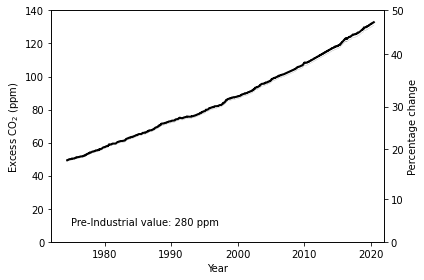

In [663]:
def excess_CO2():
    from astropy.io import ascii
    df = ascii.read('./data_CO2').to_pandas()
    df.columns=['Year','CO2_excess']
    fig,ax = plt.subplots()
    ax.plot(df.Year, df.CO2_excess,color='black',lw=2)
    ax.set_xlabel('Year')
    ax.set_ylabel(r'Excess CO$_2$ (ppm)')
    ax.set_ylim(0,140)
    ax.set_xlim(1972,2022)
    plt.annotate("Pre-Industrial value: 280 ppm",xy=(1975,10))
    ax2 = ax.twinx()
    ax2.plot(df.Year, df.CO2_excess,color='black',lw=0.1)
    ax2.set_ylim(0,140)
    ticks = ax.get_yticks()
    ax2.set_yticks([0,26,57,83,115,142])
    ax2.set_yticklabels([0,10,20,30,40,50])
    ax2.set_ylabel('Percentage change')
    ax2.grid(False)
    ax.grid(False)
    plt.tight_layout()

    plt.savefig('ExcessCO2.pdf')
excess_CO2()

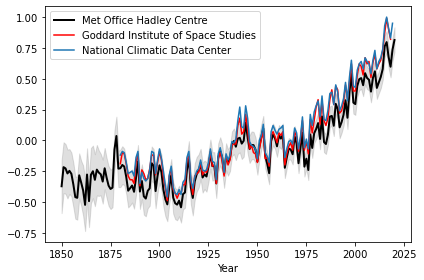

In [664]:
def temp_intcrease():
    df = ascii.read('./HadCRUT.4.6.0.0.annual_ns_avg.txt').to_pandas()
    df2 = ascii.read('./GLB.Ts+dSST.txt').to_pandas()
    df3=pd.read_csv('1880-2019.csv')
    fig,ax = plt.subplots()
    ax.plot(df.col1, df.col2,color='black',lw=2,label='Met Office Hadley Centre')
    ax.plot(df2.col20.iloc[1:-1].astype(float).values,df2.col14.iloc[1:-1].astype(float).values/100,label='Goddard Institute of Space Studies',color='red')
    ax.plot(df3.Year, df3.Value,label='National Climatic Data Center')
    ax.set_xlabel('Year')
    ax.fill_between(df.col1, df.col11,df.col12,color='grey',alpha=0.25)
    #ax.set_ylabel(r'Excess CO$_2$ (ppm)')
    #ax.set_ylim(0,140)
    #ax.set_xlim(1972,2022)
    #plt.annotate("Pre-Industrial value: 280 ppm",xy=(1975,10))
    plt.legend()
    plt.tight_layout()
    plt.savefig('Temp_increase.pdf')
temp_intcrease()